In [1]:
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import sys
sys.path.append('../../CppToPython')

import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import pandas as pd

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

np.random.seed(23)

In [4]:
# Just for the first epoch
def generate_data(N_domain=1750, N_boundary=150):
    # Points in the domain
    x_in = torch.rand((N_domain, 2))  # [x0, x1] ∈ Ω
    mu_in = (torch.rand((1, 2)) * 0.9 + 0.1).expand(N_domain, -1) # [mu0, mu1] ∈ [0.1, 1]^2

    # Points on the border of the domain (edge of the square)
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)

    xb = torch.cat([
        torch.cat([x0, zeros], dim=1),
        torch.cat([x0, ones], dim=1),
        torch.cat([zeros, x0], dim=1),
        torch.cat([ones, x0], dim=1)
    ], dim=0)

    mu_b = mu_in[:N_boundary*4, :]
    return x_in, mu_in, xb, mu_b

In [5]:
# For all the other epochs, it samples on the point on the domain in which the loss is higher so that he can learn better
def adaptive_sample(model, N_tot=5000, N_sel=1750, N_boundary=150):
    X = torch.rand(N_tot, 2)
    M = (torch.rand(N_tot, 2) * 0.9 + 0.1)

    # Compute the residual
    X.requires_grad_(True)
    R_vals = R(X, M, model).detach().abs().cpu().numpy().flatten()  # .detach() spezza il grafo

    idx = np.argsort(R_vals)[-N_sel:]
    x_int = X.detach()[idx]  
    mu_int = M.detach()[idx]

    # Point on the border
    x0 = torch.rand(N_boundary, 1)
    zeros = torch.zeros_like(x0)
    ones = torch.ones_like(x0)
    xb = torch.cat([
        torch.cat([x0, zeros], 1),
        torch.cat([x0, ones], 1),
        torch.cat([zeros, x0], 1),
        torch.cat([ones, x0], 1)
    ], 0)
    mu_b = (torch.rand(1, 2) * 0.9 + 0.1).expand(xb.shape[0], -1)

    return x_int, mu_int, xb, mu_b

In [6]:
# x: [N, 2], mu: [N, 2]
def R(x, mu, net):
    x.requires_grad_(True)
    mu.requires_grad_(False)

    u = net(x, mu)  # output shape: [N, 1]

    # Compute the gradient ∇u (i.e. du/dx e du/dy)
    grads = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # shape [N, 2]
    u_x = grads[:, 0].unsqueeze(1)  # du/dx
    u_y = grads[:, 1].unsqueeze(1)  # du/dy

    # Laplacian = d²u/dx² + d²u/dy²
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(u_y.sum(), x, create_graph=True)[0][:, 1].unsqueeze(1)
    laplacian_u = u_xx + u_yy

    # Nonlinear term
    mu0 = mu[:, 0].unsqueeze(1)
    mu1 = mu[:, 1].unsqueeze(1)
    nonlinear = (mu0 / mu1) * (torch.exp(mu1 * u) - 1)

    # Forcing term g(x)
    x0 = x[:, 0].unsqueeze(1)
    x1 = x[:, 1].unsqueeze(1)
    g = 100 * torch.sin(2 * torch.pi * x0) * torch.cos(2 * torch.pi * x1)

    # Residuo della PDE
    residual = -laplacian_u + nonlinear - g

    return residual

In [7]:
def train(model, epochs=50000, lr=1e-3, lambda_bc=1.0, patience=7500, delta=1e-4, batch_size=None, save_path="./models"):
    os.makedirs(save_path, exist_ok=True)
    start_time_total = time.time()  # ⏱ Inizio del timer totale

    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_phys_loss = float('inf')
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    using_lbfgs = False

    loss_history_total = []
    loss_history_phys = []
    loss_history_bc = []
    times_per_epoch = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        x_in, mu_in, xb, mu_b = generate_data()

        if epoch != 0:
            x_in, mu_in, xb, mu_b = adaptive_sample(model)

        try:
            if not using_lbfgs:
                optimizer.zero_grad()
                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

                loss_total = loss_phys + lambda_bc * loss_bc

                if torch.isnan(loss_total):
                    raise ValueError("NaN detected in Adam loss computation")

                loss_total.backward()
                optimizer.step()

                if loss_phys.item() + delta < best_phys_loss:
                    best_phys_loss = loss_phys.item()
                    best_model_state = model.state_dict()
                    best_model_path = os.path.join(save_path, f"model_best.pth")
                    torch.save(best_model_state, best_model_path)
                    torch.save(best_model_state, "PINNResNet.pth")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if loss_total.item() < 1e-4:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

                if loss_bc.item() < 1e-1 and loss_phys.item() < 1e-1:
                    print(f"\nSwitching to LBFGS at epoch {epoch}")
                    using_lbfgs = True
                    optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
                    if best_model_state:
                        model.load_state_dict(best_model_state)

            else:
                def closure():
                    optimizer.zero_grad()
                    loss_phys_cl = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                    u_b_cl = model(xb, mu_b)
                    loss_bc_cl = mse_loss(u_b_cl, torch.zeros_like(u_b_cl))
                    loss_total_cl = loss_phys_cl + lambda_bc * loss_bc_cl

                    if torch.isnan(loss_total_cl):
                        raise ValueError("NaN detected in LBFGS loss computation")

                    loss_total_cl.backward()
                    return loss_total_cl

                optimizer.step(closure)

                loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))
                u_b = model(xb, mu_b)
                loss_bc = mse_loss(u_b, torch.zeros_like(u_b))
                loss_total = loss_phys + lambda_bc * loss_bc

                if loss_total.item() < 1e-3:
                    final_model_path = os.path.join(save_path, "model_total_loss_e-4_PINNResNet.pth")
                    torch.save(model.state_dict(), final_model_path)
                    print(f"\n💾 Total loss reached e-4 at epoch {epoch}. Model saved at {final_model_path}")
                    break

        except ValueError as e:
            print(f"\n❌ Training stopped due to error at epoch {epoch}: {str(e)}")
            if best_model_state:
                print("🔄 Reverting to best model state before NaN.")
                model.load_state_dict(best_model_state)
                torch.save(best_model_state, "PINNResNet.pth")
                nan_model_path = os.path.join(save_path, f"model_nan_epoch{epoch}.pth")
                torch.save(model.state_dict(), nan_model_path)
            break

        loss_history_total.append(loss_total.item())
        loss_history_phys.append(loss_phys.item())
        loss_history_bc.append(loss_bc.item())
        times_per_epoch.append(time.time() - start_time)

        if epoch % 500 == 0 or epoch == epochs - 1:
            opt_name = "Adam" if not using_lbfgs else "LBFGS"
            print(f"[{opt_name}] Epoch {epoch} - Total: {loss_total.item():.2e} | PDE: {loss_phys.item():.2e} | BC: {loss_bc.item():.2e}")

        if not using_lbfgs and epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch} | Best PDE loss: {best_phys_loss:.2e}")
            model.load_state_dict(best_model_state)
            break

    # Salva comunque il modello finale
    final_model_path = os.path.join(save_path, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)

    # Plotta le perdite
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history_total, label='Total Loss')
    plt.plot(loss_history_phys, label='PDE Loss')
    plt.plot(loss_history_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss trends over training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Statistiche finali sul tempo
    total_epochs = len(loss_history_total)
    avg_time = sum(times_per_epoch) / total_epochs
    total_time = time.time() - start_time_total
    print(f"\n✅ Training complete: {total_epochs} epochs")
    print(f"⏱ Average time per epoch: {avg_time:.4f} seconds")
    print(f"⏱ Total training time: {total_time:.2f} seconds")

    return None


In [8]:
def validation(model, epochs=10, lambda_bc=1.0):
   
    mse_loss = nn.MSELoss()
    loss_bc = 1
    loss_phys = 1 

    for epoch in range(epochs):   
             
        x_in, mu_in, xb, mu_b = generate_data()
        
        model.eval()

        # Phiycial Loss (residual PDE)
        loss_phys = mse_loss(R(x_in, mu_in, model), torch.zeros_like(x_in[:, :1]))

        # Boundary Loss (Dirichlet)
        u_b = model(xb, mu_b)
        loss_bc = mse_loss(u_b, torch.zeros_like(u_b))

        # Total Loss 
        loss_total = loss_phys + lambda_bc * loss_bc

        print(f"Epoch {epoch} - Loss: {loss_total.item():.6e}  [PDE: {loss_phys.item():.2e}, BC: {loss_bc.item():.2e}]")

[Adam] Epoch 0 - Total: 2.54e+03 | PDE: 2.54e+03 | BC: 0.00e+00
[Adam] Epoch 500 - Total: 3.80e+03 | PDE: 3.80e+03 | BC: 0.00e+00
[Adam] Epoch 1000 - Total: 3.62e+03 | PDE: 3.62e+03 | BC: 0.00e+00
[Adam] Epoch 1500 - Total: 3.00e+03 | PDE: 3.00e+03 | BC: 0.00e+00
[Adam] Epoch 2000 - Total: 1.78e+03 | PDE: 1.78e+03 | BC: 0.00e+00
[Adam] Epoch 2500 - Total: 1.33e+03 | PDE: 1.33e+03 | BC: 0.00e+00
[Adam] Epoch 3000 - Total: 9.73e+02 | PDE: 9.73e+02 | BC: 0.00e+00
[Adam] Epoch 3500 - Total: 7.54e+02 | PDE: 7.54e+02 | BC: 0.00e+00
[Adam] Epoch 4000 - Total: 5.21e+02 | PDE: 5.21e+02 | BC: 0.00e+00
[Adam] Epoch 4500 - Total: 4.05e+02 | PDE: 4.05e+02 | BC: 0.00e+00
[Adam] Epoch 5000 - Total: 2.89e+02 | PDE: 2.89e+02 | BC: 0.00e+00
[Adam] Epoch 5500 - Total: 1.81e+02 | PDE: 1.81e+02 | BC: 0.00e+00
[Adam] Epoch 6000 - Total: 9.06e+01 | PDE: 9.06e+01 | BC: 0.00e+00
[Adam] Epoch 6500 - Total: 3.62e+01 | PDE: 3.62e+01 | BC: 0.00e+00
[Adam] Epoch 7000 - Total: 1.29e+01 | PDE: 1.29e+01 | BC: 0.00e+00

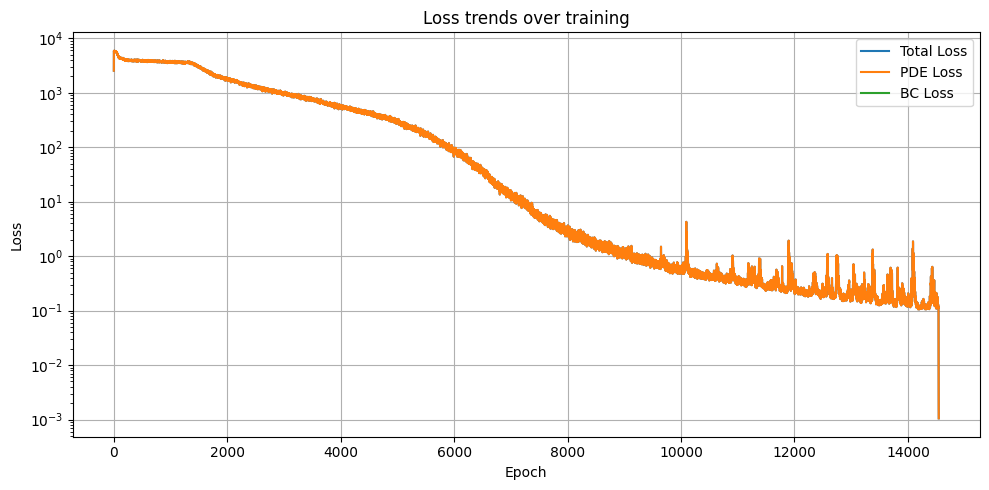


✅ Training complete: 14545 epochs
⏱ Average time per epoch: 0.0668 seconds
⏱ Total training time: 973.80 seconds
Epoch 0 - Loss: nan  [PDE: nan, BC: nan]
Epoch 1 - Loss: nan  [PDE: nan, BC: nan]
Epoch 2 - Loss: nan  [PDE: nan, BC: nan]
Epoch 3 - Loss: nan  [PDE: nan, BC: nan]
Epoch 4 - Loss: nan  [PDE: nan, BC: nan]
Epoch 5 - Loss: nan  [PDE: nan, BC: nan]
Epoch 6 - Loss: nan  [PDE: nan, BC: nan]
Epoch 7 - Loss: nan  [PDE: nan, BC: nan]
Epoch 8 - Loss: nan  [PDE: nan, BC: nan]
Epoch 9 - Loss: nan  [PDE: nan, BC: nan]


In [9]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)



PINNHardBC = PINNHardBC()
train(PINNHardBC)
validation(PINNHardBC)

#### Results
✅ Training complete: 14545 epochs

⏱ Average time per epoch: 0.0668 seconds

⏱ Total training time: 973.80 seconds

In [ ]:
validation(net)

### Results validation
For val we use the best_model and not the final one. These are the results
Epoch 0 - Loss: 6.124769e-02  [PDE: 6.12e-02, BC: 0.00e+00]

Epoch 1 - Loss: 4.985606e-02  [PDE: 4.99e-02, BC: 0.00e+00]

Epoch 2 - Loss: 4.076854e-02  [PDE: 4.08e-02, BC: 0.00e+00]

Epoch 3 - Loss: 4.958423e-02  [PDE: 4.96e-02, BC: 0.00e+00]

Epoch 4 - Loss: 9.341646e-02  [PDE: 9.34e-02, BC: 0.00e+00]

Epoch 5 - Loss: 6.680162e-02  [PDE: 6.68e-02, BC: 0.00e+00]

Epoch 6 - Loss: 5.113051e-02  [PDE: 5.11e-02, BC: 0.00e+00]

Epoch 7 - Loss: 4.847141e-02  [PDE: 4.85e-02, BC: 0.00e+00]

Epoch 8 - Loss: 4.053899e-02  [PDE: 4.05e-02, BC: 0.00e+00]

Epoch 9 - Loss: 4.005321e-02  [PDE: 4.01e-02, BC: 0.00e+00]

In [ ]:
# 15- PINNHardBC
def boundary_factor(x):
    return x[:,0]*(1 - x[:,0])*x[:,1]*(1 - x[:,1])  # vanish on boundary

class PINNHardBC(nn.Module):
    def __init__(self, width=60):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )
    def forward(self, x, mu):
        xmu = torch.cat((x, mu), dim=1)
        return boundary_factor(x).unsqueeze(1) * self.net(xmu)


net = PINNHardBC()
net.load_state_dict(torch.load("model_best.pth", map_location="cpu")) # CHANGE HERE THE NAME

net.eval() # Put the net in eval mode

model_name = "PINNHardBC"
save_csv_file(model_name)

sol_quad_pinn, der_x_quad_pinn, der_y_quad_pinn = csv(model_name)

errors_u_set = compute_L2_H1_errors_separated(sol_quad_hf,der_x_quad_hf,der_y_quad_hf, sol_quad_pinn,der_x_quad_pinn,der_y_quad_pinn, weights=quadratureWeights)

### Results on quadrature points
L2 absolute error (mean): 2.1109e-02

L2 relative error (mean): 4.1729e-02

H1 absolute error (mean): 9.8945e-01

H1 relative error (mean): 2.1799e-01